# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Check Dataset before we begin 

In [2]:
data_path = 'Dicoding/train.csv'
df_twitter = pd.read_csv(data_path)
print(df_twitter.info())
df_twitter.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
None


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [3]:
df_twitter.dropna(inplace=True)
print(df_twitter.info())

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB
None


In [4]:
df_twitter['sentiment'].value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

In [5]:
# We will focus on selected_text only
df_twitter_selected = df_twitter[['selected_text', 'sentiment']]
df_twitter_selected.head(10)

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative
5,http://www.dothebouncy.com/smf - some shameles...,neutral
6,fun,positive
7,Soooo high,neutral
8,Both of you,neutral
9,Wow... u just became cooler.,positive


# Preprocessing

In [6]:
# since we have 3 label of sentiment, we will use one hot encoding
sentiment = pd.get_dummies(df_twitter.sentiment)
df_baru = pd.concat([df_twitter_selected, sentiment], axis=1)
df_baru = df_baru.drop(columns='sentiment')
df_baru.head(10)

,selected_text,negative,neutral,positive
0,"I`d have responded, if I were going",False,True,False
1,Sooo SAD,True,False,False
2,bullying me,True,False,False
3,leave me alone,True,False,False
4,"Sons of ****,",True,False,False
5,http://www.dothebouncy.com/smf - some shameles...,False,True,False
6,fun,False,False,True
7,Soooo high,False,True,False
8,Both of you,False,True,False
9,Wow... u just became cooler.,False,False,True


In [7]:
selected_text = df_baru['selected_text'].values
label = df_baru[['negative', 'neutral', 'positive']].values

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(selected_text, label, test_size=0.2)

In [9]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (21984,)
x_test shape: (5496,)
y_train shape: (21984, 3)
y_test shape: (5496, 3)


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

OOV_TOKEN = '<OOV>'
sentence_length = 20

tokenizer = Tokenizer(oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(x_train) 
tokenizer.fit_on_texts(x_test)
 
sekuens_train = tokenizer.texts_to_sequences(x_train)
sekuens_test = tokenizer.texts_to_sequences(x_test)
 
padded_train = pad_sequences(sekuens_train, maxlen=sentence_length) 
padded_test = pad_sequences(sekuens_test, maxlen=sentence_length)

In [11]:
# count tokenizer
word_index = tokenizer.word_index
print('Jumlah kata unik:', len(word_index))

Jumlah kata unik: 17831


# Create Model

In [12]:
# create callback (stop training if accuracy > 90%)
# Define the callback function
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print("\nValidation accuracy is above 90%, so stopping training!")
            self.model.stop_training = True

In [13]:
import tensorflow as tf

# Model LSTM with CNN
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, 128, input_length=sentence_length),
    tf.keras.layers.Conv1D(128, 5, activation='tanh'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer='Nadam',metrics=['accuracy'])

In [14]:
# Add the callback to the fit method
history = model.fit(padded_train, y_train, epochs=10, batch_size=64,
                    validation_data=(padded_test, y_test), verbose=1,
                    callbacks=[MyCallback()])

Epoch 1/10
344/344 [==============================] - 15s 33ms/step - loss: 0.6123 - accuracy: 0.7400 - val_loss: 0.4575 - val_accuracy: 0.8246
Epoch 2/10
344/344 [==============================] - 11s 32ms/step - loss: 0.3208 - accuracy: 0.8882 - val_loss: 0.4455 - val_accuracy: 0.8395
Epoch 3/10
344/344 [==============================] - 11s 33ms/step - loss: 0.1928 - accuracy: 0.9393 - val_loss: 0.5033 - val_accuracy: 0.8362
Epoch 4/10
344/344 [==============================] - 11s 31ms/step - loss: 0.1269 - accuracy: 0.9619 - val_loss: 0.5604 - val_accuracy: 0.8271
Epoch 5/10
344/344 [==============================] - 11s 32ms/step - loss: 0.0886 - accuracy: 0.9739 - val_loss: 0.6108 - val_accuracy: 0.8251
Epoch 6/10
344/344 [==============================] - 11s 32ms/step - loss: 0.0720 - accuracy: 0.9794 - val_loss: 0.7024 - val_accuracy: 0.8211
Epoch 7/10
344/344 [==============================] - 12s 34ms/step - loss: 0.0581 - accuracy: 0.9847 - val_loss: 0.7325 - val_accuracy:

# Plot History

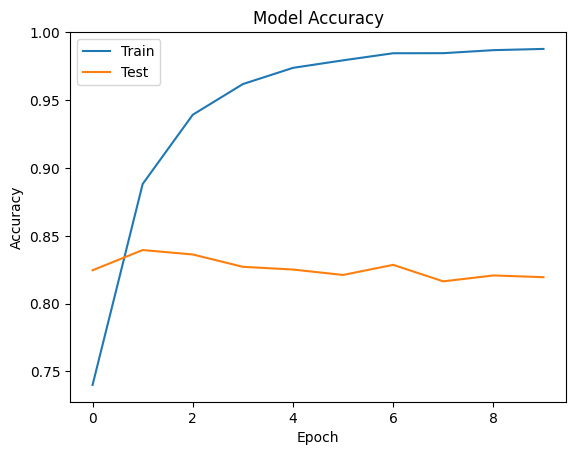

In [15]:
# plot history train
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# create info plot
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

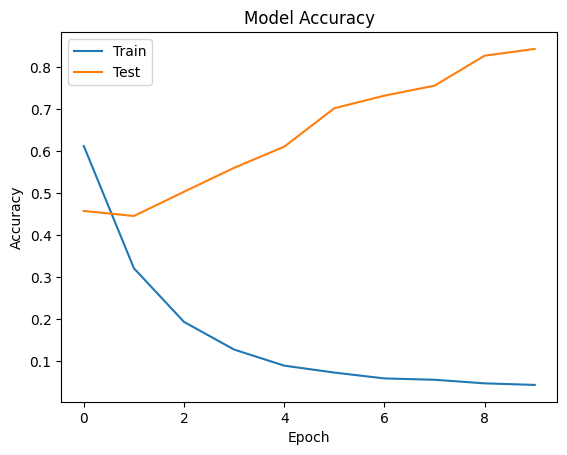

In [16]:
# plot history train
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# create info plot
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')